**Data Set**  
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$  
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$  
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$  
10000개의 데이터를 만들고 8000개를 train set으로, 1000개를 validation set로, 나머지 1000개는 test data set으로 둔다.  

생성된 데이터의 shape
X: (10000, 2)
y: (10000,)


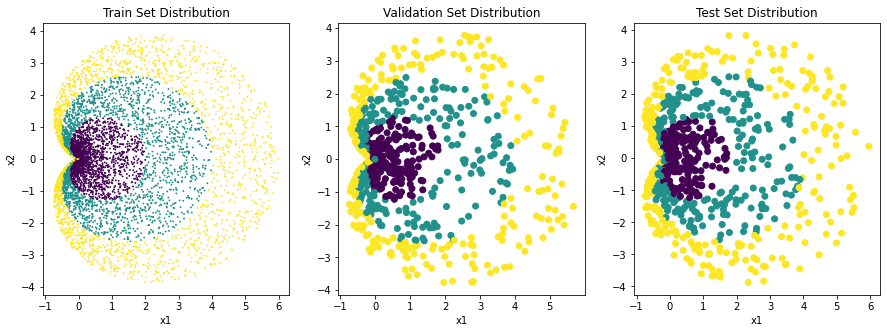

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ====== Generating Dataset ====== #
r = np.random.rand(10000)*3 #0~3사이의 랜덤한 실수 10000개
theta = np.random.rand(10000)*2*np.pi #다양한 랜덤 세타 10000개
y = r.astype(int) #실수로 정수로 바꾼다, y는 10000개의 길이를 가짐
r = r * (np.cos(theta) + 1)# r의 범위가 0~3 -> 0~6, 이 부분의 연산 덕분에 분포가 조개모양으로 나온다.
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T
print("생성된 데이터의 shape")
print("X: "+ str(np.shape(X)))
print("y: "+ str(np.shape(y)))

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)#s는 데이터의 사이즈
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

모델을 구현한다. softmax함수는 nn.CrossEntropyLoss 함수에 구현되어 있기 때문에 따로 구현하지 않아도 된다고 한다  
**Multi-Label Logistic Model**   
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$  
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$  


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$  

$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$  

$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$  

In [2]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__() #내부에 있는 forward등을 호출
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200, bias=True)
        self.linear2 = nn.Linear(in_features=200, out_features=3, bias=True)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

![nn](7-1.jpg)

local_minimal에 빠질 위험이 있기 때문에 cost를 구할 때, MSE는 잘 사용하지 않는다고 함  
![nn2](7-2.jpg)

![nn2](7-3.JPG)

CrossEntropyLoss()  
입력: N X (Num_class)  
출력: N X 1  

In [3]:
cls_loss = nn.CrossEntropyLoss()

In [10]:
test_pred_y = torch.Tensor([[0.8,0.1, 0.1],[0.1,0.8, 0.1],[0.1, 0.1, 0.8]])
test_pred_y2 = torch.Tensor([[10, 1, 1], [1, 10, 1], [1, 1, 10]])
test_true_y1 = torch.Tensor([0,1,2]).long()#INT형
test_true_y2 = torch.Tensor([2,0,1]).long()
print(cls_loss(test_pred_y2, test_true_y1))
print(cls_loss(test_pred_y2, test_true_y2))

tensor(0.0002)
tensor(9.0002)


$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$  
$$ 맞은개수/전체개수 로 정확도를 측정한다 $$  
모델의 train mode와 eval모드를 바꿔가면서 dropout같은 기능을 관리한다고 함  

detach(): PyTorch docs에 따르면 "Returns a new Tensor, detached from the current graph. The result will never require gradient." 즉 graph에서 분리한 새로운 tensor를 리턴한다. 파이토치는 tensor에서 이루어진 모든 연산을 추적해서 기록해놓는다(graph). 이 연산 기록으로 부터 도함수가 계산되고 역전파가 이루어지게 된다. detach()는 이 연산 기록으로 부터 분리한 tensor을 반환하는 method이다.  


1203 parameters


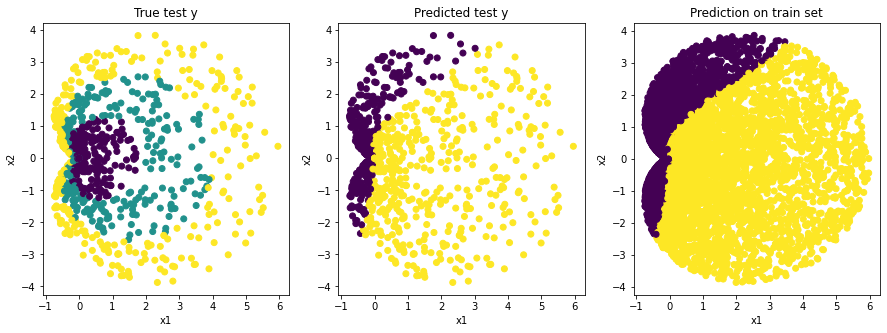

Epoch:  0 Accuracy:  30.7 %


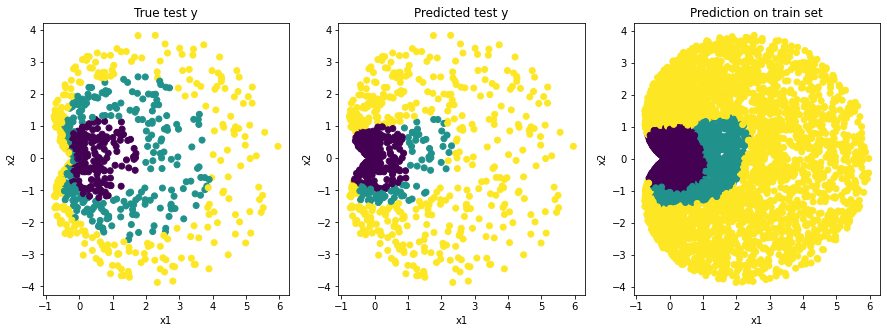

Epoch:  200 Accuracy:  58.4 %


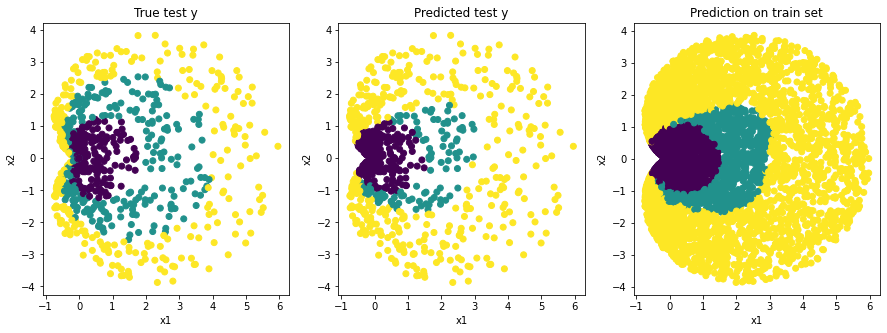

Epoch:  400 Accuracy:  65.4 %


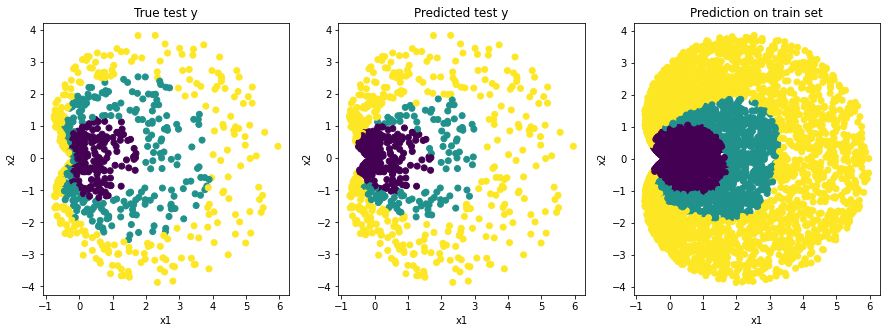

Epoch:  600 Accuracy:  68.7 %


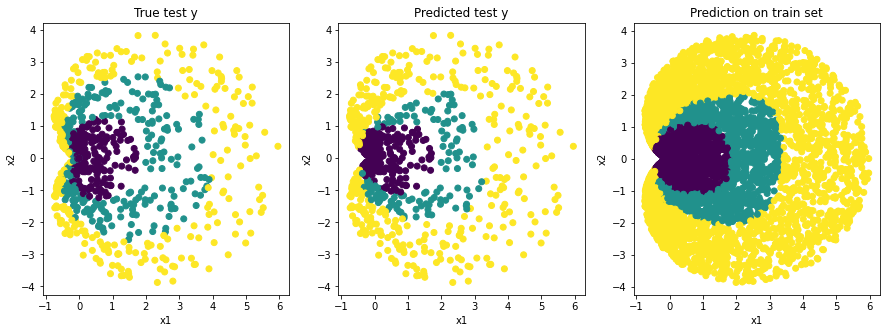

Epoch:  800 Accuracy:  71.1 %


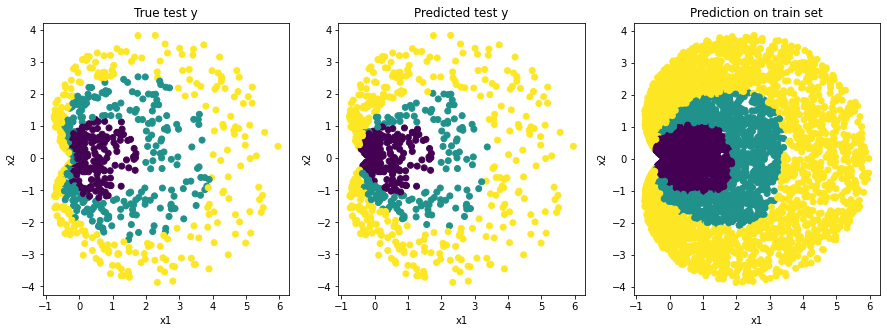

Epoch:  1000 Accuracy:  72.7 %


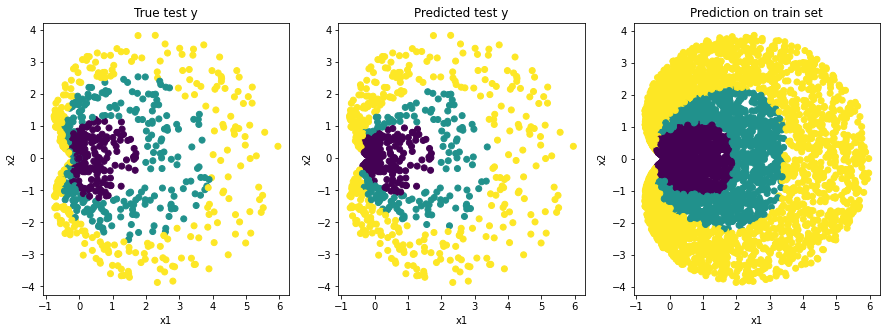

Epoch:  1200 Accuracy:  73.3 %


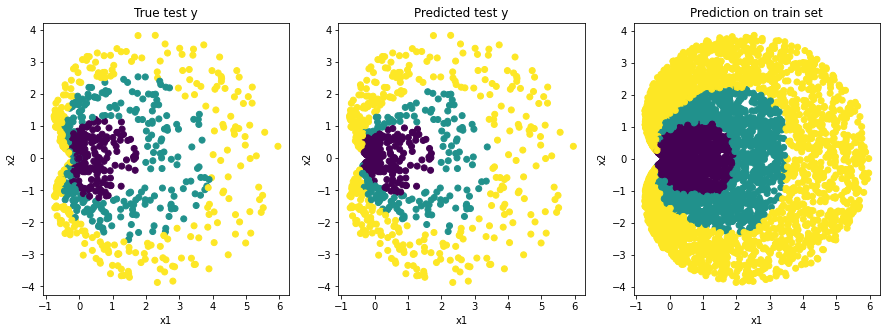

Epoch:  1400 Accuracy:  73.3 %


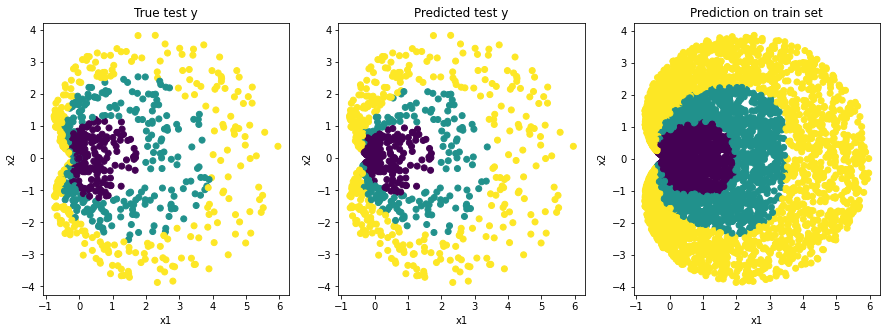

Epoch:  1600 Accuracy:  74.3 %


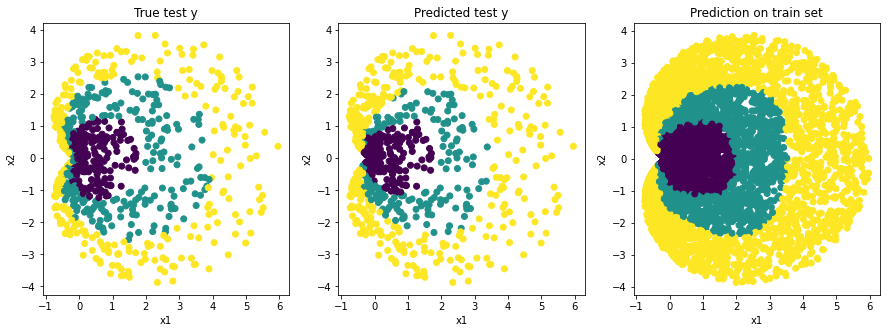

Epoch:  1800 Accuracy:  74.4 %


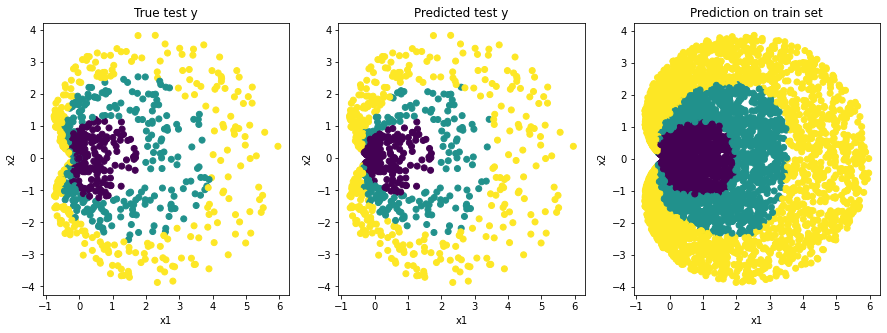

Epoch:  2000 Accuracy:  75.2 %


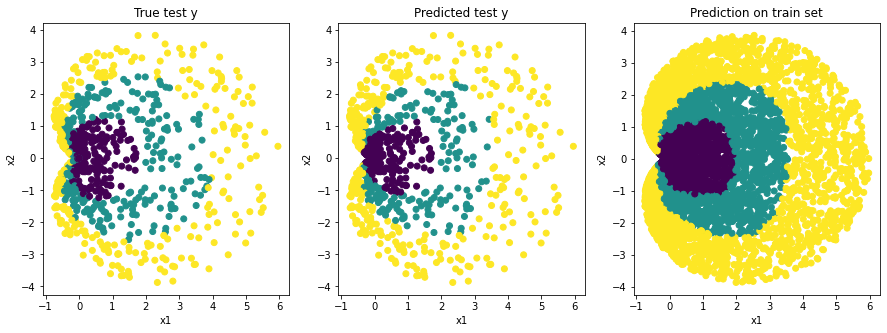

Epoch:  2200 Accuracy:  76.4 %


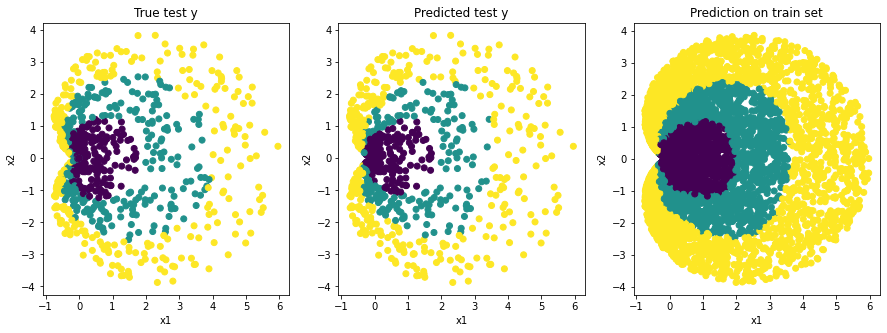

Epoch:  2400 Accuracy:  77.0 %


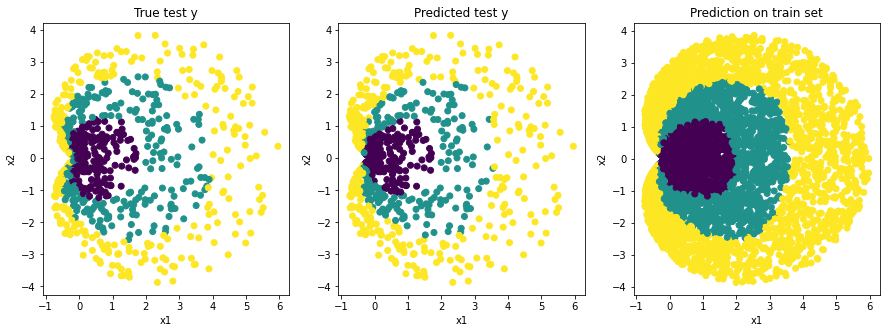

Epoch:  2600 Accuracy:  77.5 %


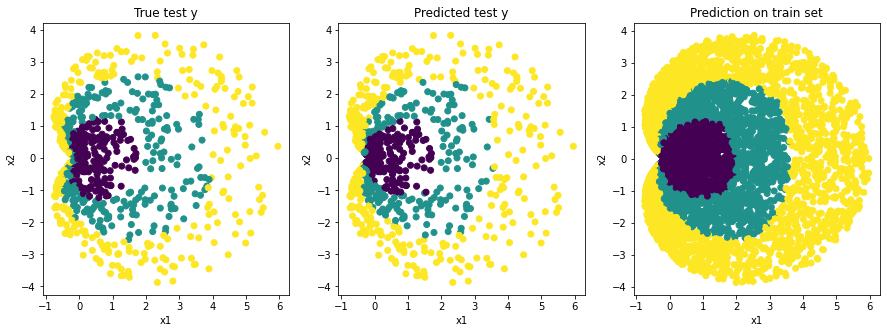

Epoch:  2800 Accuracy:  77.5 %


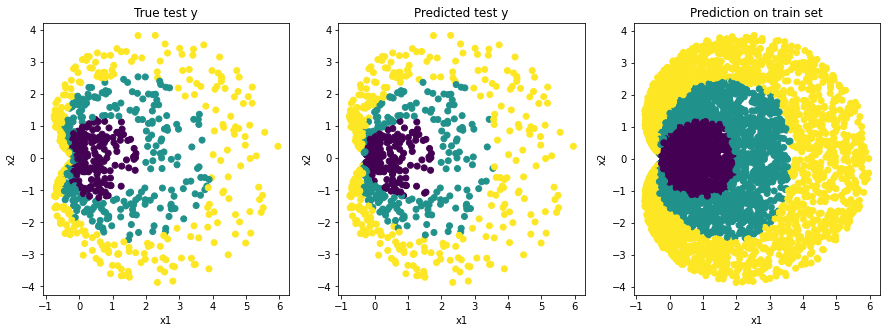

Epoch:  3000 Accuracy:  78.10000000000001 %


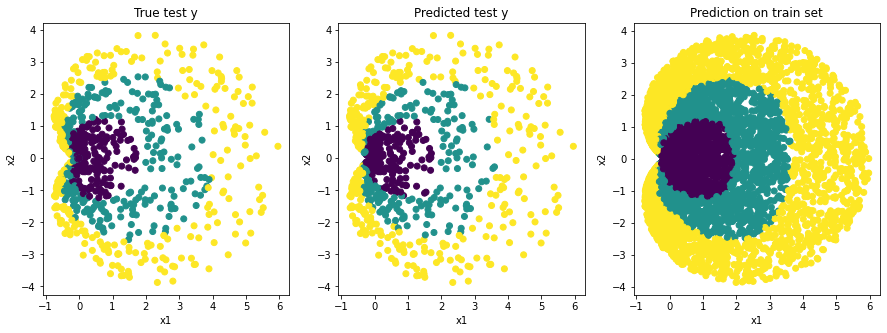

Epoch:  3200 Accuracy:  78.3 %


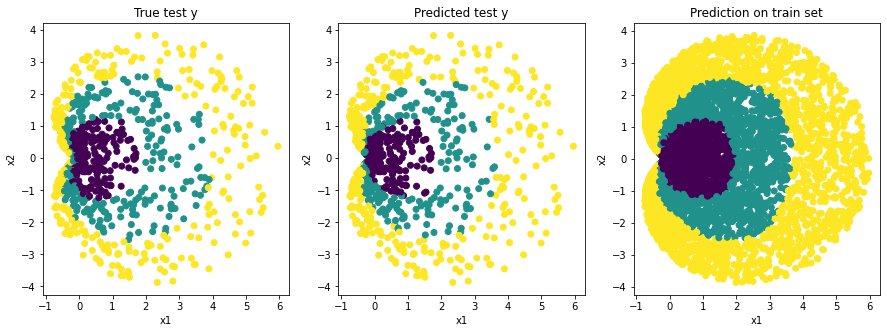

Epoch:  3400 Accuracy:  78.5 %


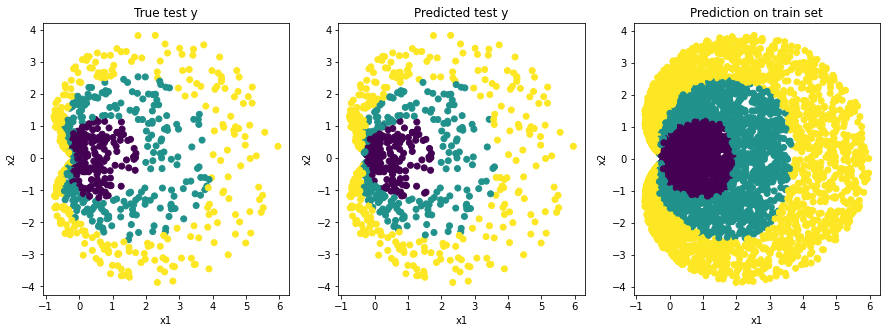

Epoch:  3600 Accuracy:  78.8 %


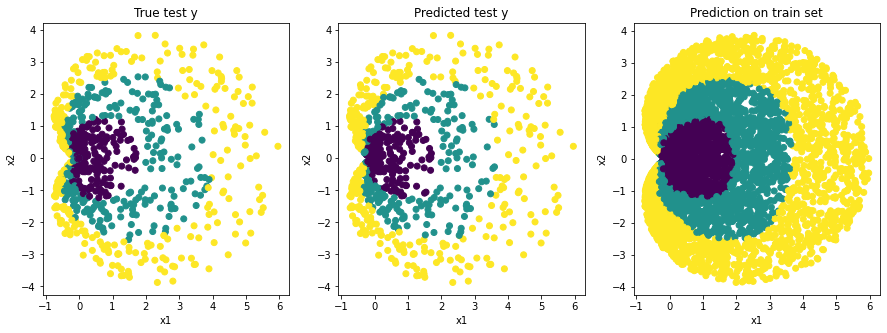

Epoch:  3800 Accuracy:  79.2 %


In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

model = MLPModel() # Model을 생성
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))# 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드

lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)
epoch = 4000 #학습 횟수를 지정
# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 생성
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

for i in range(epoch):
    model.train() # 모델을 train모드로 세팅
    optimizer.zero_grad() # 잔여 gradient를 제거
    
    input_x = torch.Tensor(train_X) # [8000, 2]
    true_y = torch.Tensor(train_y).long() # [8000]
    pred_y = model(input_x) # [8000, 3]
    
    loss = cls_loss(pred_y, true_y)
    loss.backward()
    optimizer.step()
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())#loss.item을 사용하여도 된다
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0:
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        #print(np.shape(pred_y))
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() #[1000,3] -> [1000, 1]
        #print(np.shape(pred_y))
        acc = accuracy_score(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

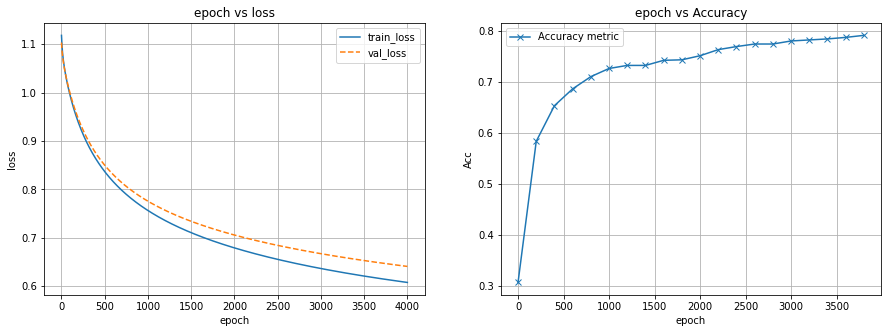

In [6]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()